In [1]:
%reload_ext autoreload
%autoreload 2
from spice_net import *
from helpers import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from PySpice.Logging.Logging import setup_logging

In [10]:
# logger = setup_logging(logging_level='INFO')

## Prelim

### Building a toy netlist with diodes

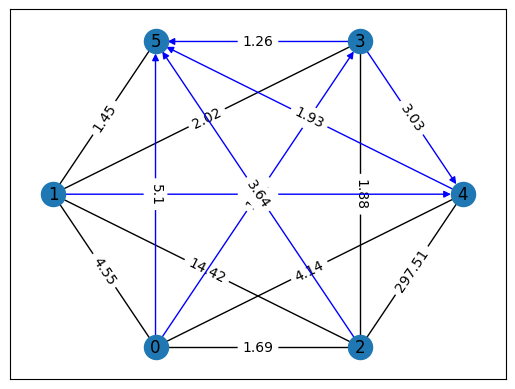

In [97]:
G = nx.erdos_renyi_graph(n=6, p=1)
thresh = 0.5
for u, v in G.edges():
    G[u][v]['weight'] = 1/np.random.rand()
    if np.random.rand() > thresh:
        G[u][v]['type'] = 'diode'
    else:
        G[u][v]['type'] = 'resistor'

vd = NonLinearNetwork('voltage_divider', con_graph=G, node_cfg=(np.array([]), np.array([])), epsilon=1e-16)
visualize(vd)

### Looking at inputs, outputs, and updates on toy dataset

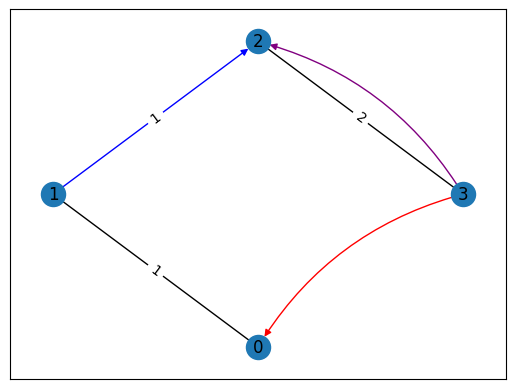

In [245]:
test_G = nx.Graph()
test_G.add_nodes_from(list(range(4)))
test_G.add_edge(0, 1, type='resistor', weight=1)
test_G.add_edge(1, 2, type='diode', weight=1)
test_G.add_edge(2, 3, type='resistor', weight=2)
test = NonLinearNetwork('test', test_G, node_cfg=([[0, 3]], [[2, 3]]))
visualize(test)

In [246]:
print(test)

.title test
.subckt e1 t_in t_out
R1 t_in dummy 1
D1 dummy t_out ReLu
.ends e1
B1 0 3
B2 2 3
Vindex index 0 1
R1 0 1 1
R2 2 3 2
Rdummy1 1 0 999999999.9999999
Rdummy2 2 0 999999999.9999999
Rdummy3 3 0 999999999.9999999
X1 1 2 e1
.model ReLu D (n=1)



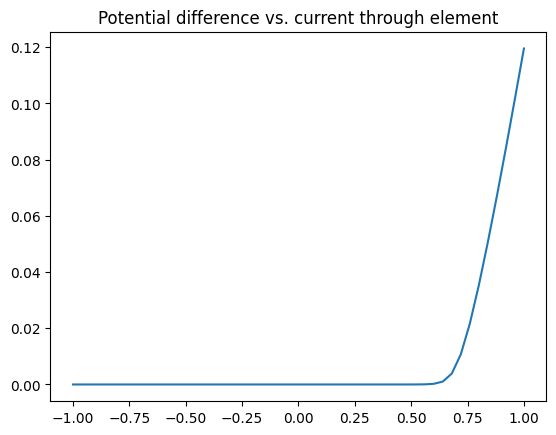

In [247]:
xs = np.linspace(-1, 1, 51)
plt.plot(xs, test.predict(xs[:, None]).squeeze())
plt.title('Potential difference vs. current through element')
plt.show()

### Handmade absolute value function example

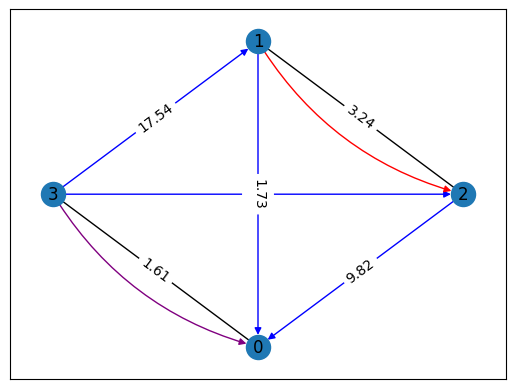

In [191]:
con_graph = nx.DiGraph()
con_graph.add_nodes_from(list(range(4)))

con_graph.add_edge(2, 1, type='resistor', weight=1./np.random.rand())
con_graph.add_edge(0, 3, type='resistor', weight=1./np.random.rand())

con_graph.add_edge(3, 1, type='diode', weight=1./np.random.rand())
con_graph.add_edge(2, 0, type='diode', weight=1./np.random.rand())
con_graph.add_edge(1, 0, type='diode', weight=1./np.random.rand())
con_graph.add_edge(3, 2, type='diode', weight=1./np.random.rand())
# con_graph.add_edge(1, 3, type='diode', weight=1./np.random.rand())
# con_graph.add_edge(0, 2, type='diode', weight=1./np.random.rand())

node_cfg = [[[2, 1]], [[0, 3]]]

handmade = NonLinearNetwork('handmade', con_graph, node_cfg)
visualize(handmade)

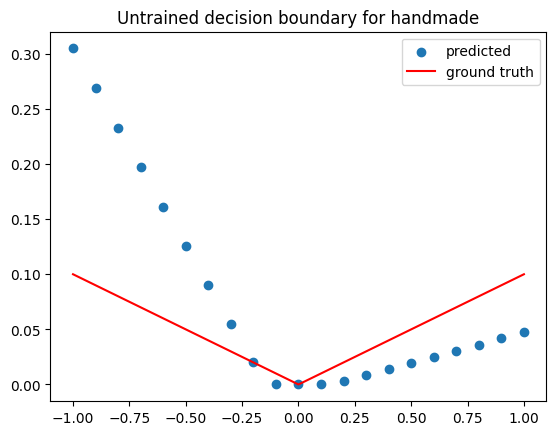

In [192]:
m = np.random.random()
m = .1
model = lambda x: np.abs(m*x)

lh = 1
num_pts = 21
xs = np.linspace(-lh, lh, num_pts)
ys = handmade.predict(xs[:, None]).squeeze()
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

In [193]:
# Train linear network
epochs = 30
trained_handmade, loss, updates, weights = train(handmade, xs[:,None], model(xs[:, None]), epochs, gamma=3, eta=0.1)

Epoch 1: 0.003311883387123847
Epoch 2: 0.0019113441746848063
Epoch 3: 0.0011875552825802095
Epoch 4: 0.0007635748403366299
Epoch 5: 0.0004945875657654257
Epoch 6: 0.0003226733766432207
Epoch 7: 0.00022659316374926502
Epoch 8: 0.00016091655095172987
Epoch 9: 0.00012026870600149558
Epoch 10: 9.600628339816945e-05
Epoch 11: 7.901834351940984e-05
Epoch 12: 6.889329268150354e-05
Epoch 13: 6.191691325163163e-05
Epoch 14: 5.833263288719601e-05
Epoch 15: 5.602465862746571e-05
Epoch 16: 5.459726645426508e-05
Epoch 17: 5.396946656994712e-05
Epoch 18: 5.3407182321297015e-05
Epoch 19: 5.316993189762262e-05
Epoch 20: 5.298114877769296e-05
Epoch 21: 5.2722098870797835e-05
Epoch 22: 5.2666179270320336e-05
Epoch 23: 5.259055170774535e-05
Epoch 24: 5.260368112794816e-05
Epoch 25: 5.256772026342455e-05
Epoch 26: 5.244764837654009e-05
Epoch 27: 5.241548499987182e-05
Epoch 28: 5.2429033939629836e-05
Epoch 29: 5.2392776746986876e-05
Epoch 30: 5.246173914442003e-05


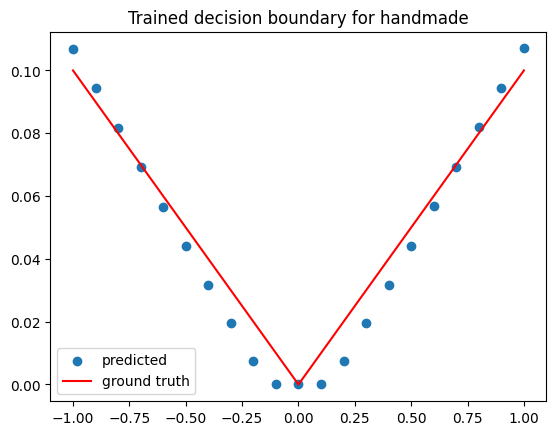

In [194]:
ys = trained_handmade.predict(xs[:, None])
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

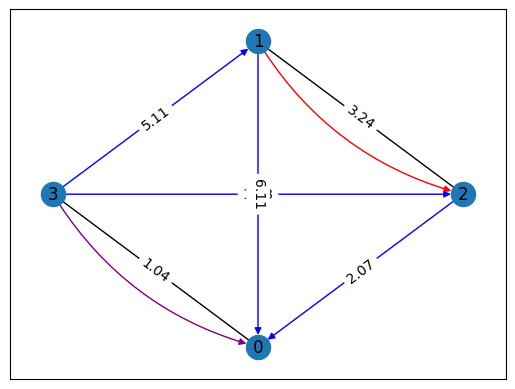

In [195]:
visualize(trained_handmade)

## Training on a nonlinear function

### Generate the dataset

In [2]:
# Generate N random points
N = 17
split = 1.
# pts = np.random.rand(N)
# pts = np.logspace(-2, 0, N)
pts = np.linspace(-2, 2, N)
sigma = 0.000

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
abs_x = parab_x = pts
log_x = np.linspace(0, 1, N)

# Generate noninear data
m = 0.1
b = .25

abs_y = m * np.abs(abs_x + b)
parab_y = m * (abs_x + b)**2
log_y = m * np.log(log_x + b)

# model = (lambda m, b: lambda x: np.log(m*x + b)/100)(m, b) 
model = (lambda m, b: lambda x: np.abs(m*(x + b)))(m, b)

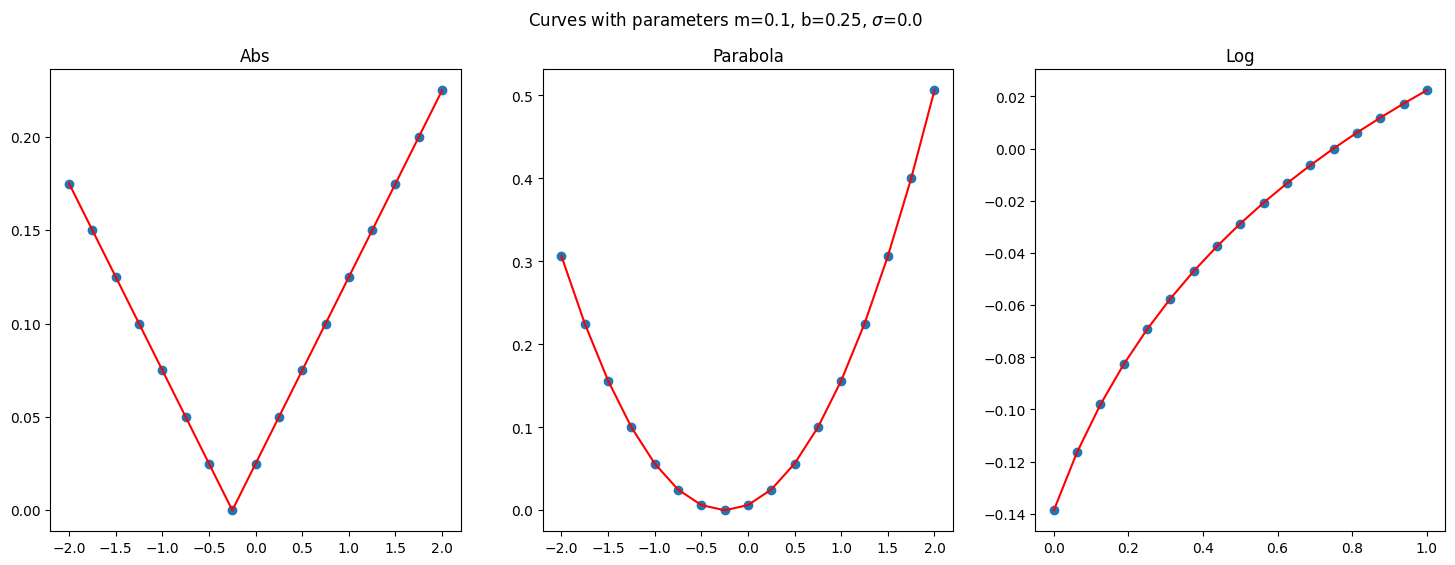

In [3]:
# Visualize dataset
xs = [abs_x, parab_x, log_x]
ys = [abs_y, parab_y, log_y]
names = ['abs', 'parabola', 'log']

fig, axs = plt.subplots(1, len(xs), figsize=(18, 6))

for i, ax in enumerate(axs):
    ax.scatter(xs[i], ys[i])
    sorted_args = np.argsort(xs[i])
    ax.plot(xs[i][sorted_args], ys[i][sorted_args], 'r',)
    ax.set_title(fr'{names[i].title()}')
fig.suptitle(fr'Curves with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

### Nonlinear, no bias voltages

#### Generate random resistor + diode network

In [4]:
# Parameters
nodes = 20
avg_deg = 6
# edge_prob = avg_deg / nodes
edge_prob = 1
diode_prob = .8

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        # if np.random.binomial(1, 0.5):
            # u, v = v, u
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() 
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand()
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 1
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 190
Num purely resistor: 35
Num diodes: 155


(array([[10,  8]]), array([[17,  4]]))

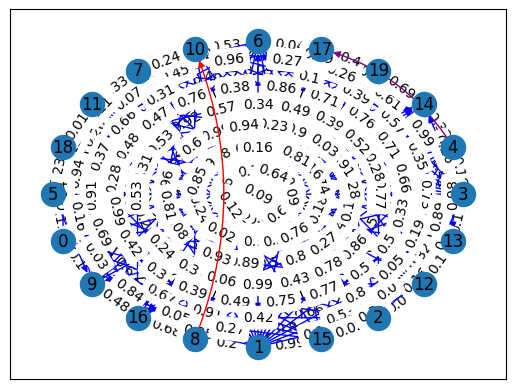

In [5]:
nets = [NonLinearNetwork(name, con_graph, node_cfg) for name in names]
visualize(nets[0], mode='y')

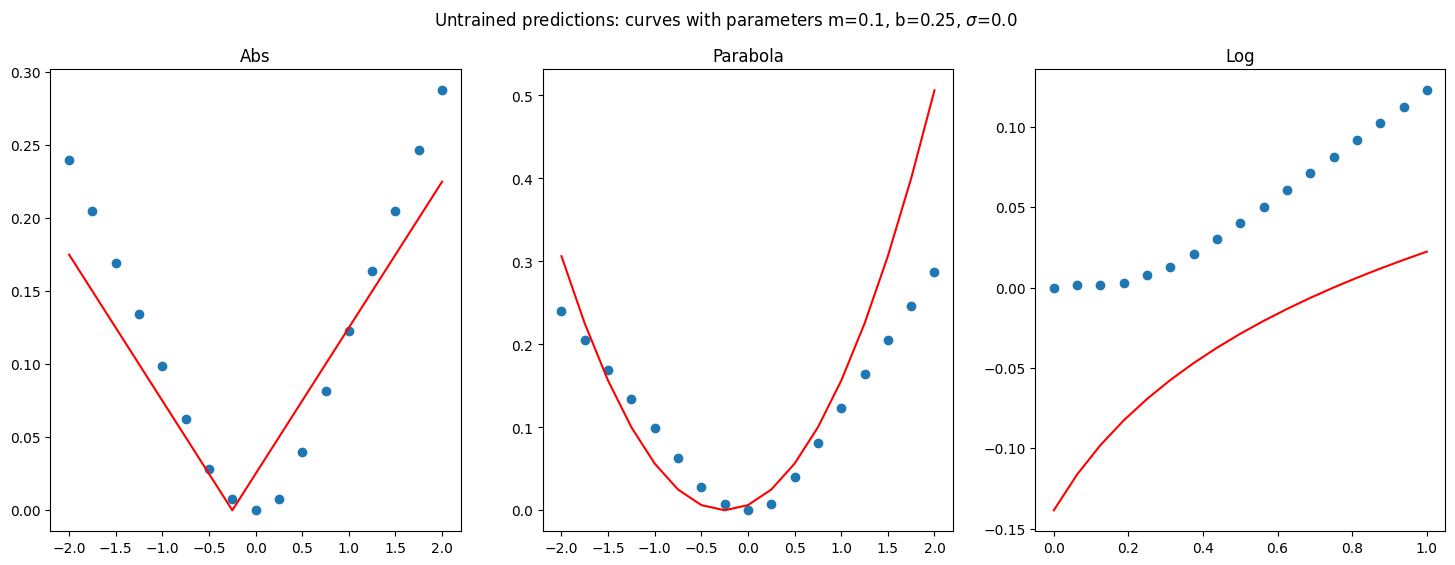

In [7]:
fig, axs = plt.subplots(1, len(xs), figsize=(18, 6))

for i, ax in enumerate(axs):
    sorted_args = np.argsort(xs[i])
    preds = nets[i].predict(xs[i][:, None])
    ax.scatter(xs[i], preds)
    ax.plot(xs[i][sorted_args], ys[i][sorted_args], 'r',)
    ax.set_title(fr'{names[i].title()}')
fig.suptitle(fr'Untrained predictions: curves with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

#### Train network

In [8]:
# Train nonlinear network
epochs = 500

alpha = 1e-2
eta = 1e-2
gamma = alpha / eta / 2


results = [train(net, x[:, None], y[:, None], epochs, gamma=gamma, eta=eta) for net, x, y in zip(nets, xs, ys)]

Epoch 1: 0.0013054392762646774
Epoch 2: 0.001297513687043457
Epoch 3: 0.0012898493863577817
Epoch 4: 0.0012823545663158663
Epoch 5: 0.0012748643133140066
Epoch 6: 0.001267610663540806
Epoch 7: 0.0012604785252674246
Epoch 8: 0.0012535996265278255
Epoch 9: 0.0012468818615640259
Epoch 10: 0.0012402724550068158
Epoch 11: 0.0012338052484940627
Epoch 12: 0.0012274596018676432
Epoch 13: 0.0012211714572038569
Epoch 14: 0.0012151133499665747
Epoch 15: 0.001209202570868229
Epoch 16: 0.0012034192638036947
Epoch 17: 0.0011975824343185117
Epoch 18: 0.0011919365787593575
Epoch 19: 0.0011864145156972484
Epoch 20: 0.0011809434838709384
Epoch 21: 0.0011755229681726933
Epoch 22: 0.0011702293444918806
Epoch 23: 0.001165136673600161
Epoch 24: 0.0011600166737931565
Epoch 25: 0.0011549421250645919
Epoch 26: 0.0011500467845851669
Epoch 27: 0.0011451841446511253
Epoch 28: 0.001140361530644528
Epoch 29: 0.0011356383636478692
Epoch 30: 0.0011308814895840623
Epoch 31: 0.001126320757149344
Epoch 32: 0.00112171771

In [30]:
import pickle
with open('results/n_1.pkl', 'wb') as f:
    pickle.dump(dict(
        graph=con_graph,
        node_cfg = node_cfg,
        results=list(map(lambda item: item[1:], results)),
    ), f)

In [14]:
with open('results/n_0.1.pkl', 'rb') as f:
    results_pkl = pickle.load(f)

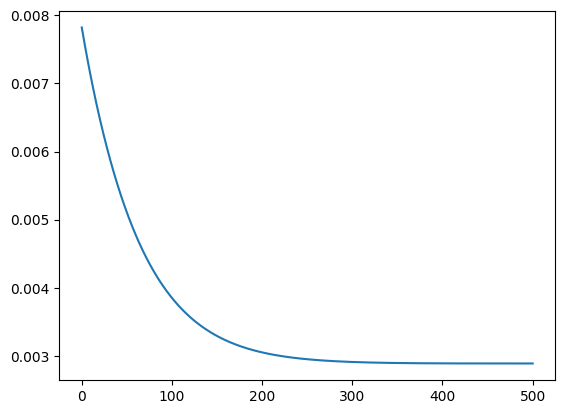

In [15]:
plt.plot(results_pkl['results'][2][0])

In [27]:
trained = []
losses = []
updates = []
weights = []
for trained_net, loss, update, weight in results:
    trained.append(trained_net)
    losses.append(loss)
    updates.append(update)
    weights.append(weight)

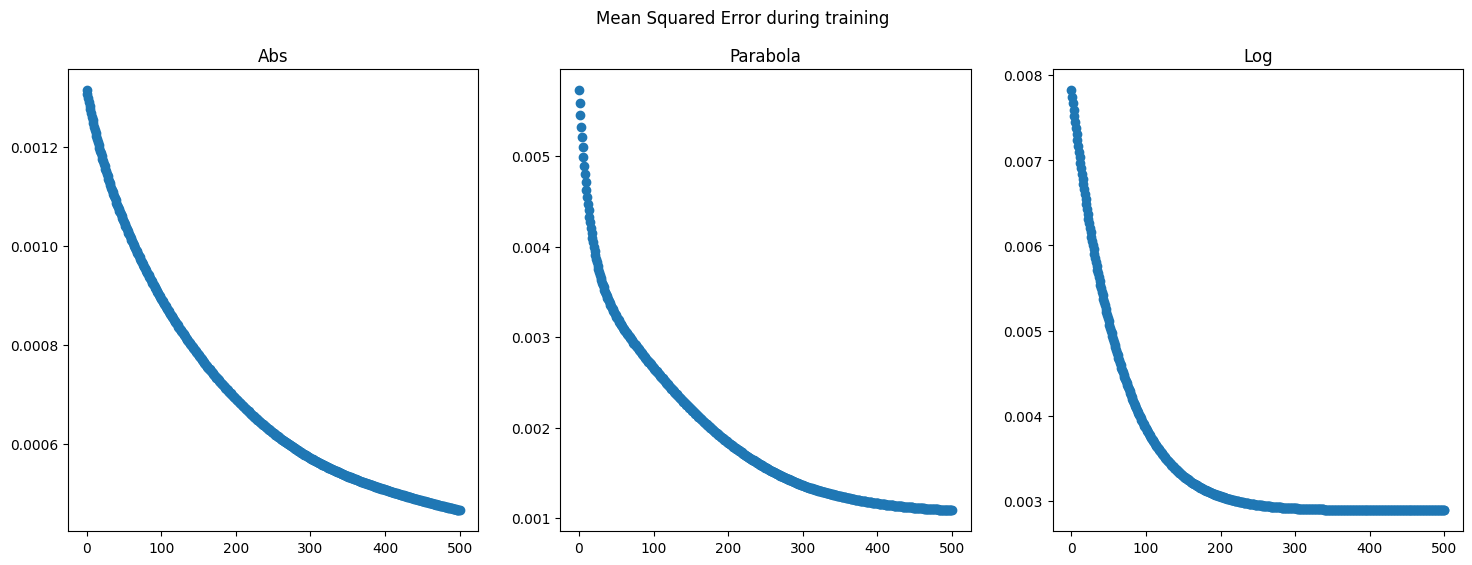

In [28]:
fig, axs = plt.subplots(1, len(xs), figsize=(18, 6))

for ax, name, loss in zip(axs, names, losses):
    ax.scatter(np.arange(loss.size), loss)
    ax.set_title(f'{name.title()}')
fig.suptitle('Mean Squared Error during training')
plt.show()

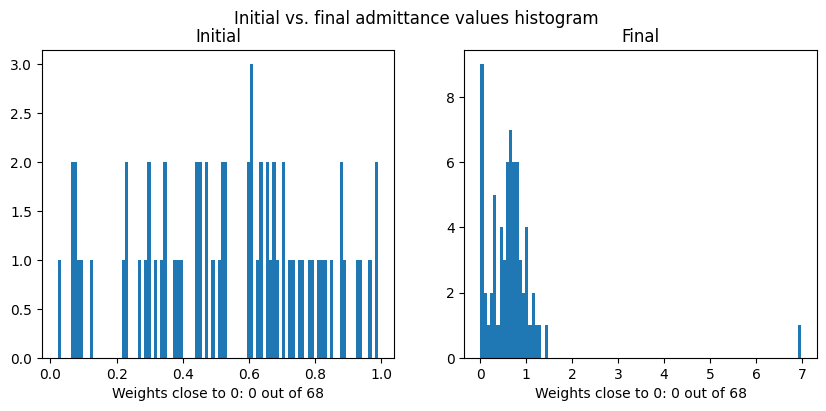

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(1./weights[0, -1], bins=100)
axs[0].set_title('Initial')
axs[0].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
axs[1].hist(1./weights[-1, -1], bins=100)
axs[1].set_title('Final')
axs[1].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
fig.suptitle('Initial vs. final admittance values histogram')
plt.show()

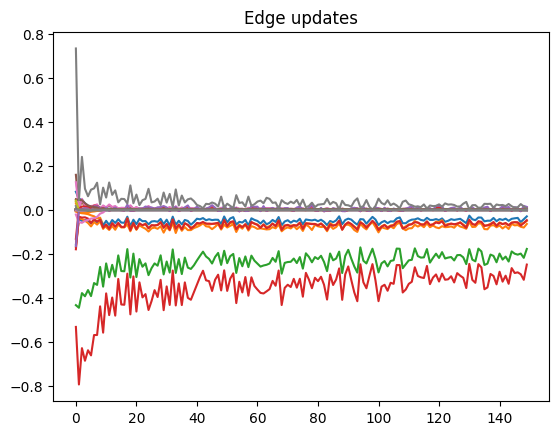

In [112]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
# plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

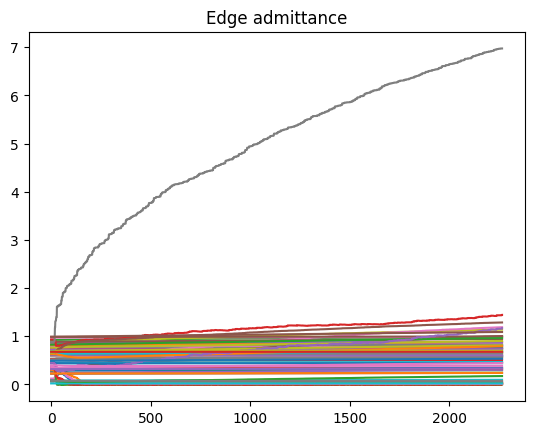

In [113]:
# plt.plot(1./weights.reshape(-1, weights.shape[-1]))
plt.plot(np.clip(1./weights.reshape(-1, weights.shape[-1]), -1, np.inf))
plt.title('Edge admittance')
plt.show()

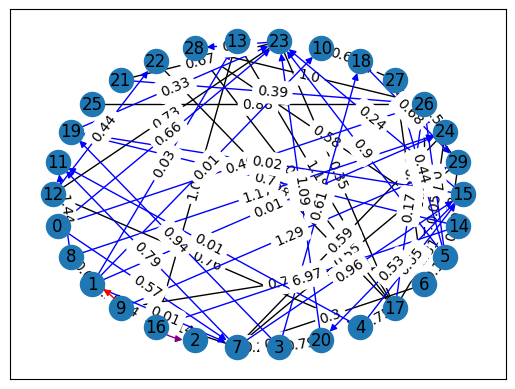

In [114]:
visualize(trained_nonlin, mode='y')

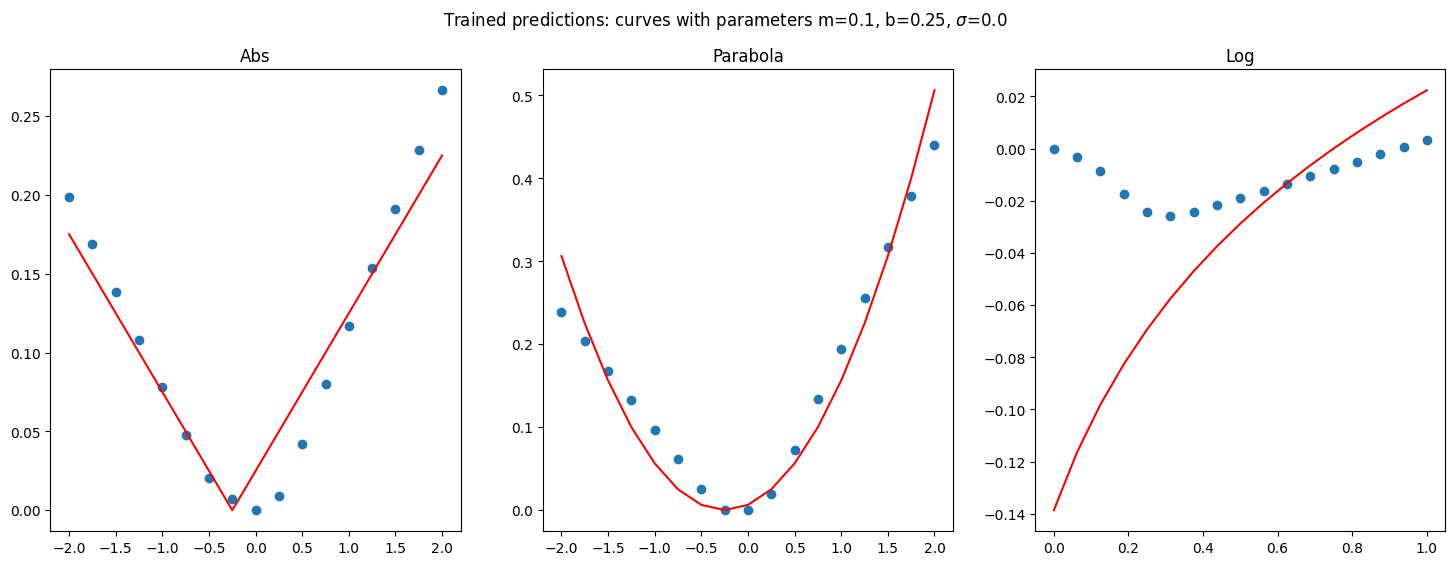

In [29]:
fig, axs = plt.subplots(1, len(xs), figsize=(18, 6))

for ax, x, y, name, trained_net in zip(axs, xs, ys, names, trained):
    sorted_args = np.argsort(x)
    preds = trained_net.predict(x[:, None])
    ax.scatter(x, preds)
    ax.plot(x[sorted_args], y[sorted_args], 'r',)
    ax.set_title(fr'{name.title()}')
fig.suptitle(fr'Trained predictions: curves with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

### Visualize training results over time

In [317]:
results_pkl

{'graph': <networkx.classes.graph.Graph at 0x724f3ba90>,
 'node_cfg': (array([[7, 9]]), array([[3, 5]])),
 'results': [(array([0.05140508, 0.05090057, 0.05042263, 0.04994813, 0.04949285,
          0.04903563, 0.0485857 , 0.04814936, 0.04770462, 0.04727724,
          0.04685451, 0.0464367 , 0.04602355, 0.04561732, 0.04521194,
          0.04480512, 0.04442272, 0.04402329, 0.04364166, 0.04326672,
          0.04288853, 0.042524  , 0.04215903, 0.04179958, 0.04143473,
          0.04107962, 0.04073656, 0.04038039, 0.04004703, 0.03970183,
          0.03936822, 0.03903152, 0.03869883, 0.03837337, 0.03804745,
          0.03773225, 0.03740612, 0.03710092, 0.0367924 , 0.03647832,
          0.03617341, 0.03586963, 0.03556796, 0.03527541, 0.03497527,
          0.03469619, 0.03455977, 0.03442479, 0.03427455, 0.03414203,
          0.03400855, 0.03387581, 0.03373646, 0.03359867, 0.03346592,
          0.03333473, 0.03319851, 0.03307371, 0.0329368 , 0.03280346,
          0.0326723 , 0.03254148, 0.0324155

In [35]:
# Set values: test_net, weights
ind = 1

with open('results/n_1.pkl', 'rb') as f:
    results_pkl = pickle.load(f)

con_graph = results_pkl['graph']
node_cfg = results_pkl['node_cfg']
losses, updates, weights = results_pkl['results'][ind]

test_net = NonLinearNetwork(f'test_{names[ind]}', con_graph, node_cfg)

x = xs[ind]
y = ys[ind]

sorted_args = np.argsort(x)
x = x[sorted_args]
y = y[sorted_args]


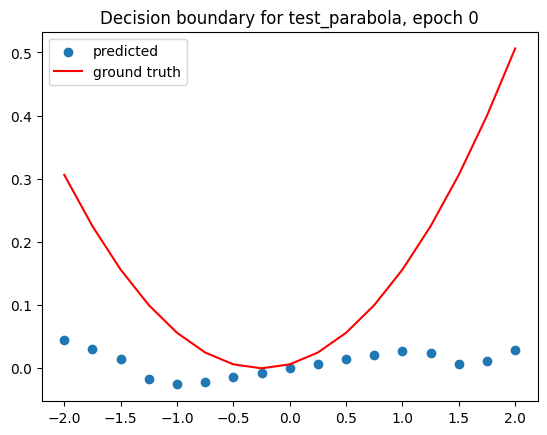

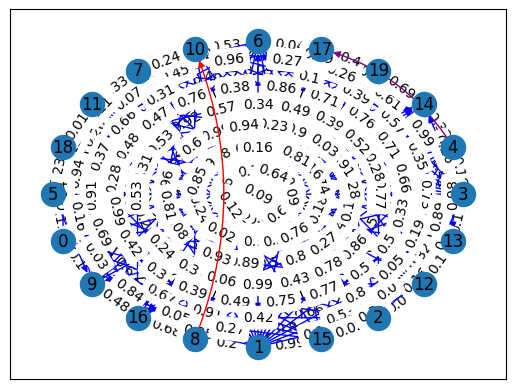

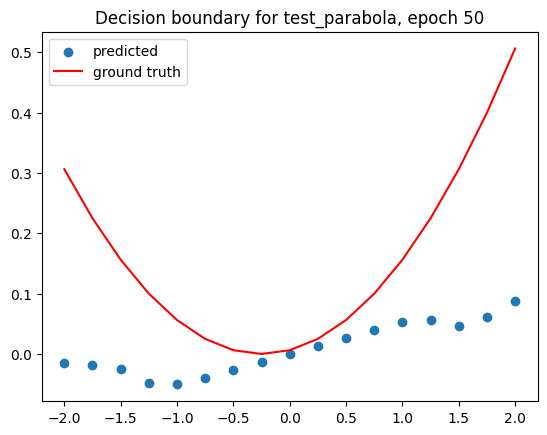

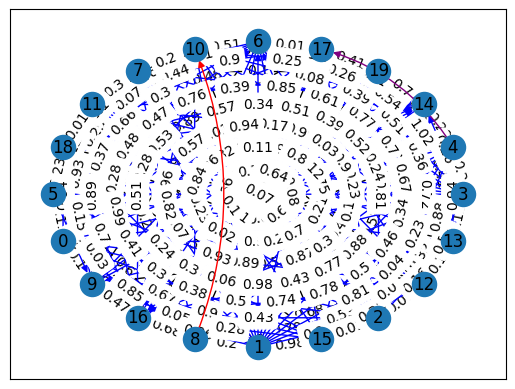

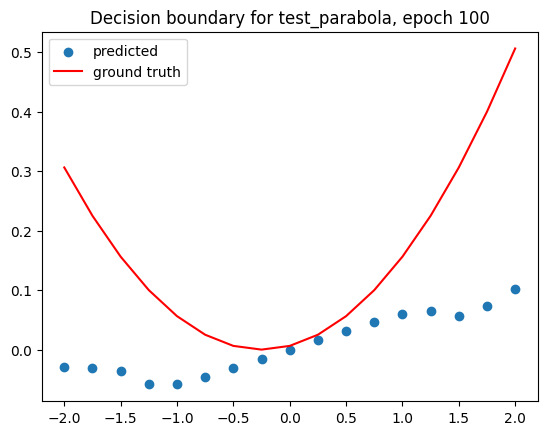

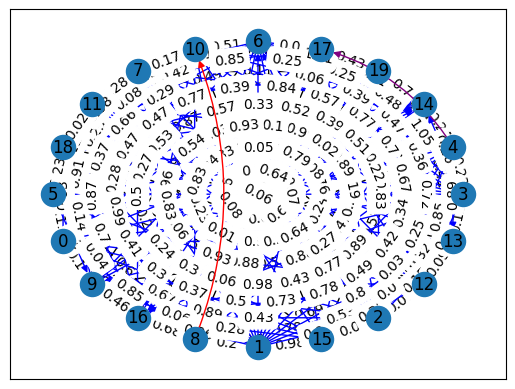

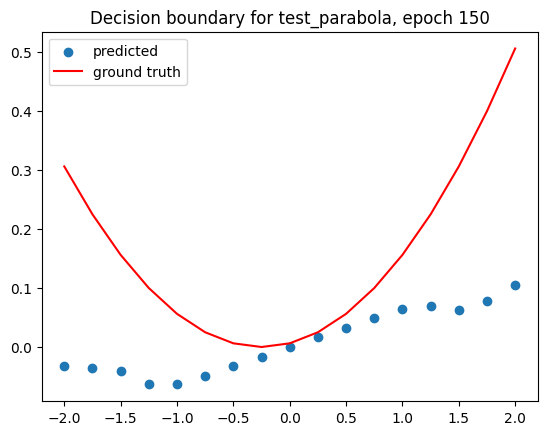

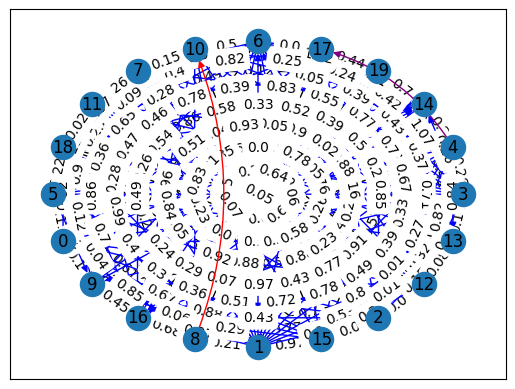

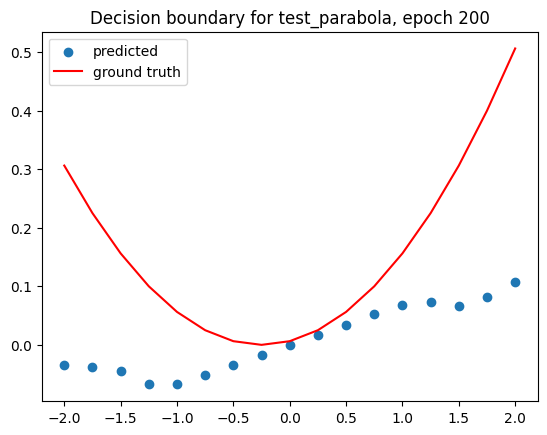

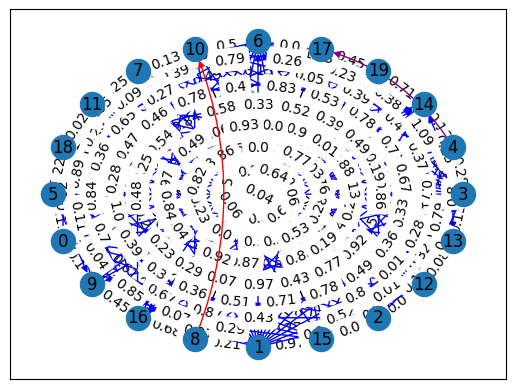

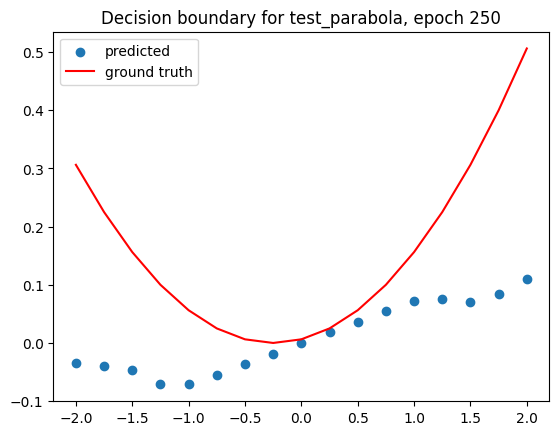

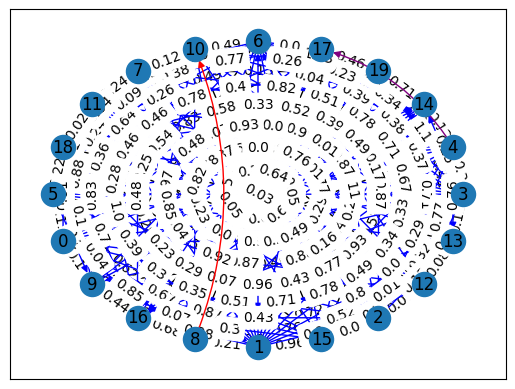

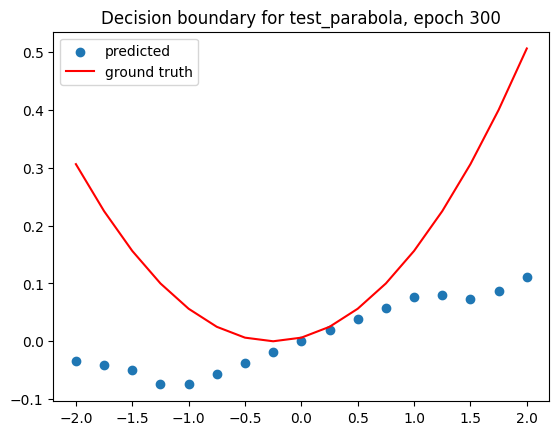

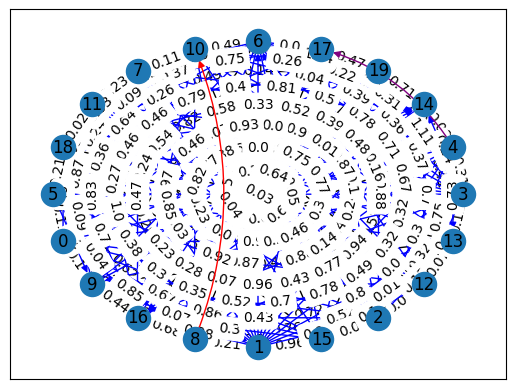

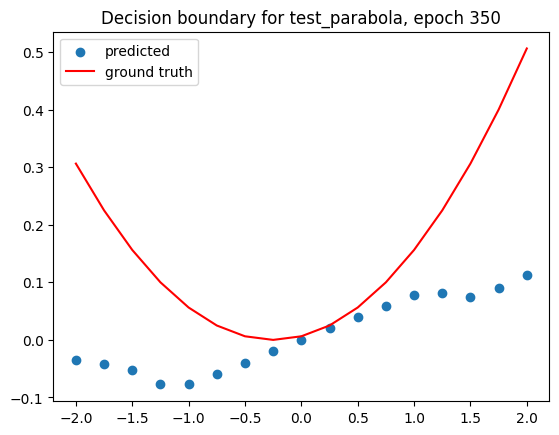

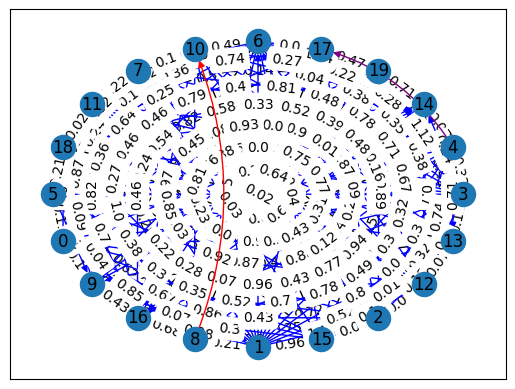

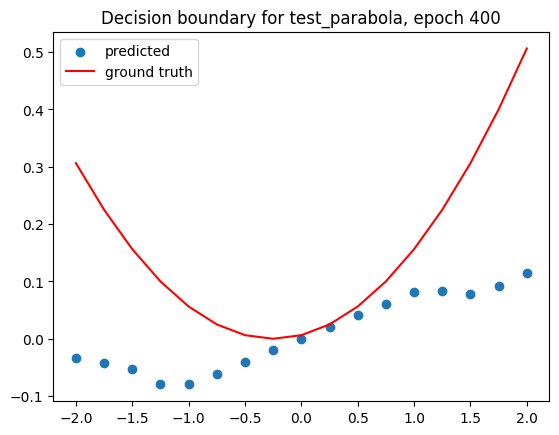

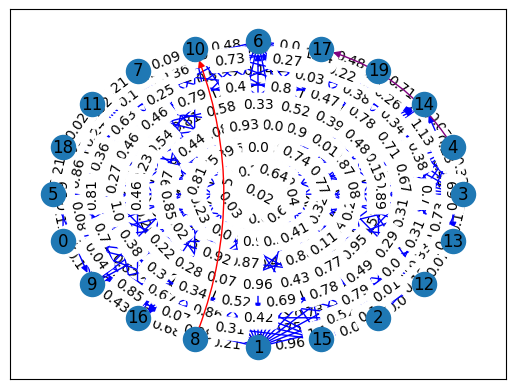

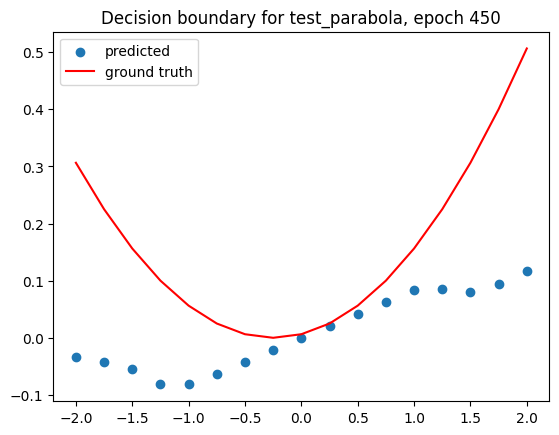

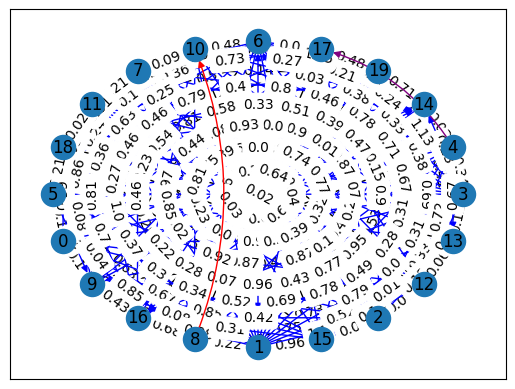

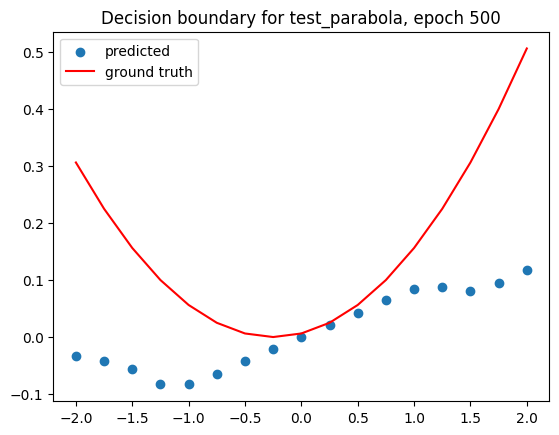

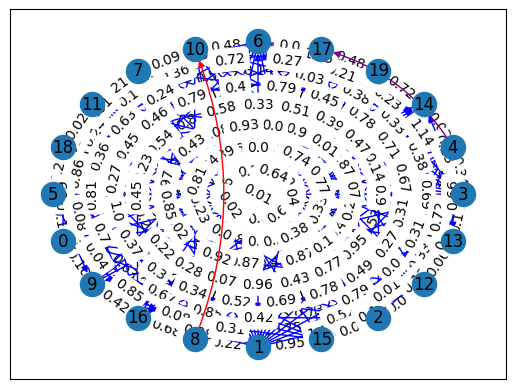

In [36]:
for test_it in range(0, epochs+1, 50):
    for i, R in enumerate(test_net.edges):
        R.resistance = weights[test_it, 0][i]

    for i, X in enumerate(test_net.nonlinear_vals):
        X.R1.resistance = weights[test_it, 0][i + len(test_net.edges)]
    lh = 1
    num_pts = 21


    # xs = np.linspace(-lh, lh, num_pts)
    # xs_bias = np.hstack((xs[:, None], np.tile(biases, (num_pts, 1))))


    preds = test_net.predict(x[:,None])
    # ys = test_net.predict(xs_bias)

    sorted 

    plt.scatter(x, preds)
    plt.plot(x, y, 'r')
    plt.title(f'Decision boundary for {test_net.name}, epoch {test_it}')
    plt.legend(['predicted', 'ground truth'])
    plt.show()
    visualize(test_net, mode='y')
    plt.show()

### Retry example with bias terms

In [208]:
# Parameters
nodes = 20
avg_deg = 4
edge_prob =  avg_deg / nodes
diode_prob = .6

# print('Num edges:', diodes + res)
# print('Num purely resistor:', res)
# print('Num diodes:', diodes)

in_nodes = 4
out_nodes = 1

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        if np.random.rand() < 0.5:
            u, v = v, u
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = np.abs(np.random.normal(1, 0.5))
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = np.abs(np.random.normal(1, 0.5))
        res += 1

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)

Num edges: 27
Num purely resistor: 9
Num diodes: 18


In [209]:
biases = np.random.normal(0, 1, size=in_nodes-1)

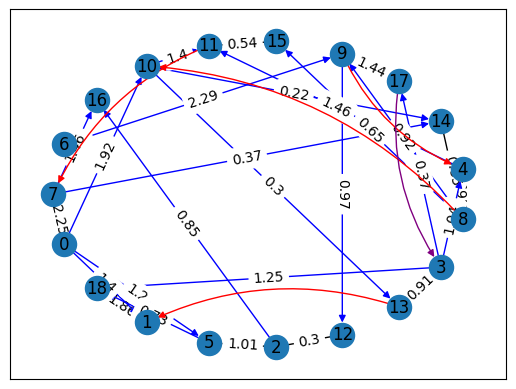

In [210]:
visualize(nonlin)

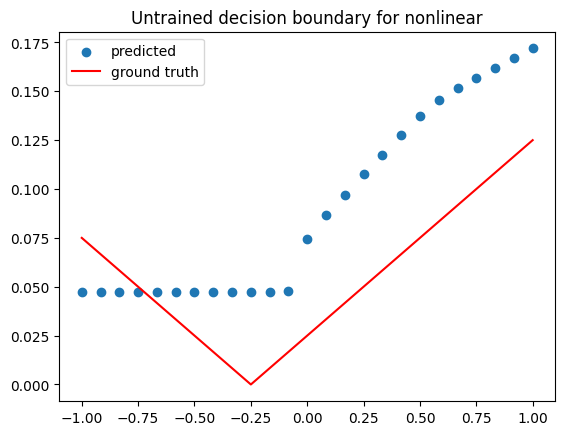

In [212]:
test_net = nonlin
lh = 1
num_pts = 25
xs = np.linspace(-lh, lh, num_pts)
ys = test_net.predict(np.hstack((xs[:, None], np.tile(biases, (num_pts, 1)))))
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [239]:
# Train nonlinear network
epochs = 50

alpha = 1e-1
eta = 1e-3
gamma = alpha / eta / 2

training_bias = np.hstack((training['x'], np.ones((training['x'].shape[0], 3))))
trained_nonlin, loss, updates, weights = train(nonlin, training_bias, training['y'], epochs, gamma=gamma, eta=eta)

Epoch 1: 0.004519516945991861
Epoch 2: 0.00449301610760452
Epoch 3: 0.004515209782560982
Epoch 4: 0.004455336895699024
Epoch 5: 0.004529318059639049
Epoch 6: 0.004503367743347408
Epoch 7: 0.0045166570019935974
Epoch 8: 0.004498683245676325
Epoch 9: 0.00449107407592589
Epoch 10: 0.004450825762500994
Epoch 11: 0.004503782094566421
Epoch 12: 0.004529225920098817
Epoch 13: 0.004530299783610471
Epoch 14: 0.00451284038460856
Epoch 15: 0.004506362237102535
Epoch 16: 0.004471390858671073
Epoch 17: 0.0045276251123496656
Epoch 18: 0.004517399909620451
Epoch 19: 0.004461760906597076
Epoch 20: 0.004503486080477927
Epoch 21: 0.0045294264787558965
Epoch 22: 0.00450059947845172
Epoch 23: 0.0044588893665887695
Epoch 24: 0.004499490639296135
Epoch 25: 0.0044810771324111836
Epoch 26: 0.004537588077995265
Epoch 27: 0.0045254128331570775
Epoch 28: 0.004503531198113661
Epoch 29: 0.004539712404526701
Epoch 30: 0.004526682076543617
Epoch 31: 0.00450773734479617
Epoch 32: 0.0045091415489988945
Epoch 33: 0.004

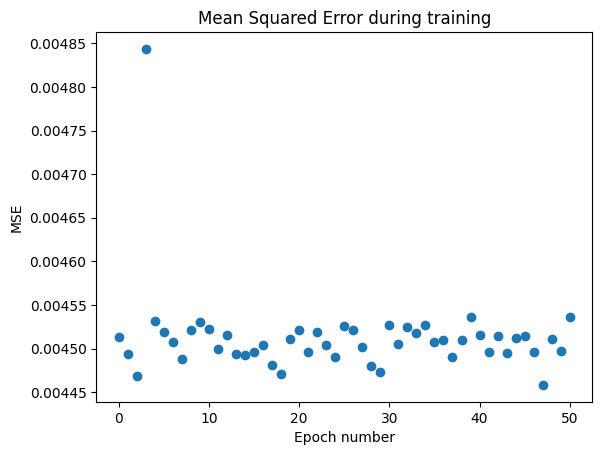

In [237]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

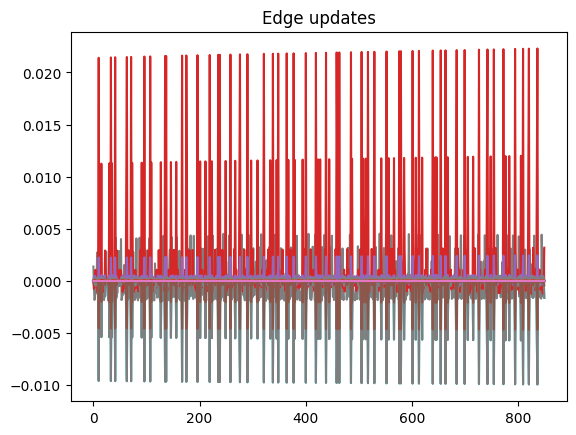

In [223]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

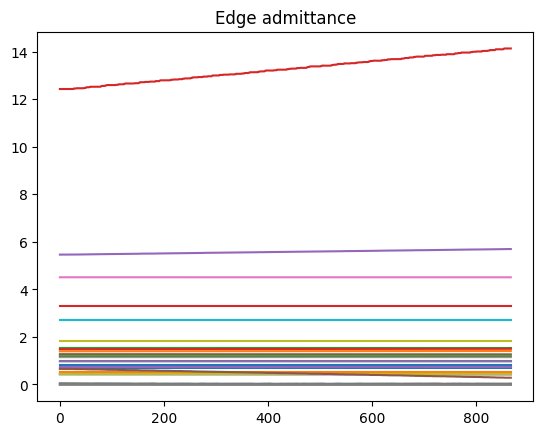

In [224]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

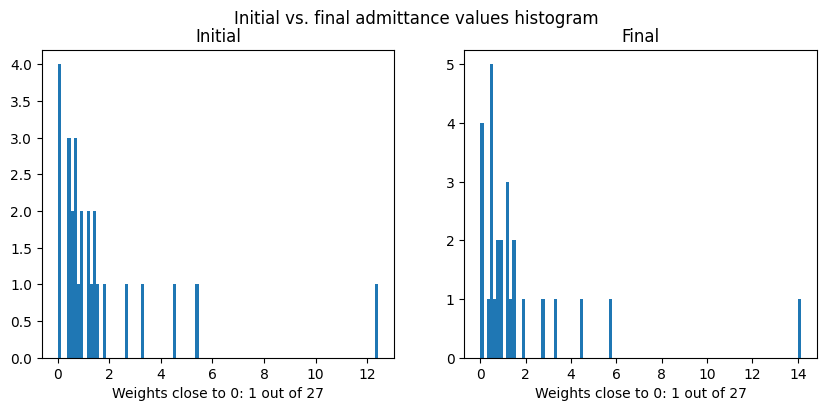

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(1./weights[0, -1], bins=100)
axs[0].set_title('Initial')
axs[0].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
axs[1].hist(1./weights[-1, -1], bins=100)
axs[1].set_title('Final')
axs[1].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
fig.suptitle('Initial vs. final admittance values histogram')
plt.show()

In [226]:
# visualize(trained_nonlin, mode='y')

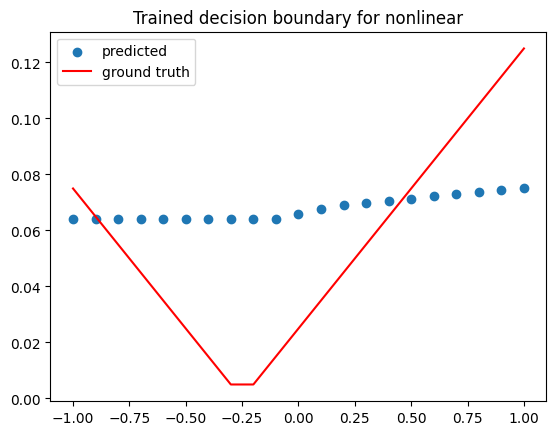

In [238]:
test_net = nonlin
ys = test_net.predict(np.hstack((xs[:, None], np.tile(biases, (num_pts, 1)))))
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()